[View in Colaboratory](https://colab.research.google.com/github/yylonly/ServeNet/blob/master/4_ServeNet(withoutLSTM).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!kill -9 -1

In [0]:
!pkill -9 -f ipykernel_launcher

In [0]:
!/opt/bin/nvidia-smi
printm()

Thu Jun  7 22:39:40 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    27W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Show GPU and CPU Status

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize


## Links your Google Drive

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/Colab Notebooks/")

In [4]:
!ls -l

total 21642
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root   45300 May 15 15:12 2ServeNet-2D-CNN-1-BI-LTSM-FC(Hyperas).ipynb
-rw-r--r-- 1 root root  702911 May  7 22:21 4.ServeNet-1-BI-LTSM(1024) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  741240 May  8 06:23 

In [5]:
seed = 12345

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(seed)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Rest of code follows ...

Using TensorFlow backend.


In [0]:
#import plaidml.keras
#plaidml.keras.install_backend()


import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average, Flatten
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional
from keras.initializers import Orthogonal

%matplotlib inline

In [7]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [8]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [9]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    embeddings = Reshape((110, 200, 1))(embeddings)
    
    cnn1 = Conv2D(128, kernel_size=(5, 5), padding='same', kernel_initializer=glorot_uniform(seed=seed))(embeddings)
    cnn1 = Dropout(0.6, seed = seed)(cnn1)
    cnn2 = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=glorot_uniform(seed=seed))(cnn1)
    cnn2 = Dropout(0.6, seed = seed)(cnn2)
    cnn3 = Conv2D(1, kernel_size=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=seed))(cnn2)
    features_cnn = Reshape((110, 200))(cnn3)
     
    flat = Flatten()(features_cnn)  
      
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(1024, activation='tanh', kernel_initializer=glorot_uniform(seed))(flat)
    X = Dropout(0.6, seed = seed)(X)
    X = Dense(400, activation='tanh', kernel_initializer=glorot_uniform(seed))(X)
    X = Dropout(0.6, seed = seed)(X)
    X = Dense(50, activation='softmax', kernel_initializer=glorot_uniform(seed))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [19]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
reshape_3 (Reshape)          (None, 110, 200, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 110, 200, 128)     3328      
_________________________________________________________________
dropout_3 (Dropout)          (None, 110, 200, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 200, 64)      73792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 110, 200, 64)      0         
__________

## Check Initial Status

In [0]:
for i in range(len(model.layers)):
  print(model.layers[i].get_weights())

[]
[array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.50368 ,  0.7717  , -0.49917 , ..., -0.29556 , -0.50476 ,
         0.94292 ],
       [ 0.45277 ,  0.56571 , -0.81527 , ..., -0.28671 , -0.37201 ,
         0.26867 ],
       ...,
       [ 0.28546 , -0.11229 ,  0.15723 , ...,  0.34378 ,  0.1648  ,
        -0.15182 ],
       [ 0.44623 , -0.14838 ,  0.6079  , ..., -0.30543 ,  0.014476,
        -0.30898 ],
       [-0.042467, -0.12213 ,  0.01372 , ..., -0.15382 , -0.11118 ,
        -0.21537 ]], dtype=float32)]
[]
[array([[[[ 0.03831549, -0.00910172,  0.03213427, ..., -0.0350462 ,
           0.00423124, -0.021443  ]],

        [[-0.04041508,  0.01374754, -0.02921108, ...,  0.03240291,
           0.03981305,  0.0227646 ]],

        [[-0.03399764,  0.00143301, -0.00528277, ..., -0.03222716,
           0.01941707,  0.00609763]],

        [[ 0.03506805,  0.0228222 ,  0.00547895, ..., -0.03405621,
          -0.02344455,  0.00699442]],

        [[ 

In [0]:
for i in range(len(model.layers)):
  print(model.layers[i].get_weights())

[]
[array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.50368 ,  0.7717  , -0.49917 , ..., -0.29556 , -0.50476 ,
         0.94292 ],
       [ 0.45277 ,  0.56571 , -0.81527 , ..., -0.28671 , -0.37201 ,
         0.26867 ],
       ...,
       [ 0.28546 , -0.11229 ,  0.15723 , ...,  0.34378 ,  0.1648  ,
        -0.15182 ],
       [ 0.44623 , -0.14838 ,  0.6079  , ..., -0.30543 ,  0.014476,
        -0.30898 ],
       [-0.042467, -0.12213 ,  0.01372 , ..., -0.15382 , -0.11118 ,
        -0.21537 ]], dtype=float32)]
[]
[array([[[[ 0.03831549, -0.00910172,  0.03213427, ..., -0.0350462 ,
           0.00423124, -0.021443  ]],

        [[-0.04041508,  0.01374754, -0.02921108, ...,  0.03240291,
           0.03981305,  0.0227646 ]],

        [[-0.03399764,  0.00143301, -0.00528277, ..., -0.03222716,
           0.01941707,  0.00609763]],

        [[ 0.03506805,  0.0228222 ,  0.00547895, ..., -0.03405621,
          -0.02344455,  0.00699442]],

        [[ 

## Training ServeNet

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [22]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 64, verbose = 1, shuffle=False)

Train on 8123 samples, validate on 2061 samples
Epoch 1/20
8123/8123 [==============================] - 79s 10ms/step - loss: 4.1236 - categorical_accuracy: 0.0572 - top_k_categorical_accuracy: 0.2050 - val_loss: 3.4324 - val_categorical_accuracy: 0.1485 - val_top_k_categorical_accuracy: 0.3935
Epoch 2/20
8123/8123 [==============================] - 73s 9ms/step - loss: 3.5238 - categorical_accuracy: 0.1591 - top_k_categorical_accuracy: 0.3946 - val_loss: 3.0123 - val_categorical_accuracy: 0.2305 - val_top_k_categorical_accuracy: 0.5318
Epoch 3/20
1600/8123 [====>.........................] - ETA: 55s - loss: 2.6460 - categorical_accuracy: 0.3200 - top_k_categorical_accuracy: 0.6088

8123/8123 [==============================] - 73s 9ms/step - loss: 2.4850 - categorical_accuracy: 0.3467 - top_k_categorical_accuracy: 0.6586 - val_loss: 3.1338 - val_categorical_accuracy: 0.2382 - val_top_k_categorical_accuracy: 0.5357
Epoch 4/20
8123/8123 [==============================] - 73s 9ms/step - loss: 1.6007 - categorical_accuracy: 0.5568 - top_k_categorical_accuracy: 0.8494 - val_loss: 3.1142 - val_categorical_accuracy: 0.2775 - val_top_k_categorical_accuracy: 0.5876
Epoch 5/20
3648/8123 [============>.................] - ETA: 37s - loss: 1.1323 - categorical_accuracy: 0.6872 - top_k_categorical_accuracy: 0.9252

8123/8123 [==============================] - 73s 9ms/step - loss: 1.0515 - categorical_accuracy: 0.7045 - top_k_categorical_accuracy: 0.9354 - val_loss: 3.2822 - val_categorical_accuracy: 0.2868 - val_top_k_categorical_accuracy: 0.5929
Epoch 6/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.6783 - categorical_accuracy: 0.8105 - top_k_categorical_accuracy: 0.9741 - val_loss: 3.6744 - val_categorical_accuracy: 0.2576 - val_top_k_categorical_accuracy: 0.5497
Epoch 7/20
4096/8123 [==============>...............] - ETA: 34s - loss: 0.5615 - categorical_accuracy: 0.8496 - top_k_categorical_accuracy: 0.9819

8123/8123 [==============================] - 73s 9ms/step - loss: 0.5446 - categorical_accuracy: 0.8488 - top_k_categorical_accuracy: 0.9812 - val_loss: 3.6290 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.5725
Epoch 8/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.4681 - categorical_accuracy: 0.8650 - top_k_categorical_accuracy: 0.9863 - val_loss: 3.9104 - val_categorical_accuracy: 0.2649 - val_top_k_categorical_accuracy: 0.5526
Epoch 9/20
4224/8123 [==============>...............] - ETA: 33s - loss: 0.4866 - categorical_accuracy: 0.8601 - top_k_categorical_accuracy: 0.9837

8123/8123 [==============================] - 73s 9ms/step - loss: 0.4720 - categorical_accuracy: 0.8626 - top_k_categorical_accuracy: 0.9842 - val_loss: 4.0753 - val_categorical_accuracy: 0.2484 - val_top_k_categorical_accuracy: 0.5386
Epoch 10/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.4356 - categorical_accuracy: 0.8686 - top_k_categorical_accuracy: 0.9882 - val_loss: 4.2830 - val_categorical_accuracy: 0.2421 - val_top_k_categorical_accuracy: 0.5255
Epoch 11/20
4224/8123 [==============>...............] - ETA: 32s - loss: 0.4111 - categorical_accuracy: 0.8731 - top_k_categorical_accuracy: 0.9884

8123/8123 [==============================] - 73s 9ms/step - loss: 0.4046 - categorical_accuracy: 0.8759 - top_k_categorical_accuracy: 0.9886 - val_loss: 4.3452 - val_categorical_accuracy: 0.2523 - val_top_k_categorical_accuracy: 0.5221
Epoch 12/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.3469 - categorical_accuracy: 0.8946 - top_k_categorical_accuracy: 0.9930 - val_loss: 4.5053 - val_categorical_accuracy: 0.2363 - val_top_k_categorical_accuracy: 0.5119
Epoch 13/20
4224/8123 [==============>...............] - ETA: 33s - loss: 0.3243 - categorical_accuracy: 0.9010 - top_k_categorical_accuracy: 0.9922

8123/8123 [==============================] - 73s 9ms/step - loss: 0.3298 - categorical_accuracy: 0.8971 - top_k_categorical_accuracy: 0.9915 - val_loss: 4.5586 - val_categorical_accuracy: 0.2402 - val_top_k_categorical_accuracy: 0.5129
Epoch 14/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.3156 - categorical_accuracy: 0.9018 - top_k_categorical_accuracy: 0.9925 - val_loss: 4.7156 - val_categorical_accuracy: 0.2494 - val_top_k_categorical_accuracy: 0.5211
Epoch 15/20
4224/8123 [==============>...............] - ETA: 33s - loss: 0.3077 - categorical_accuracy: 0.9089 - top_k_categorical_accuracy: 0.9927

8123/8123 [==============================] - 73s 9ms/step - loss: 0.2891 - categorical_accuracy: 0.9122 - top_k_categorical_accuracy: 0.9934 - val_loss: 4.5728 - val_categorical_accuracy: 0.2533 - val_top_k_categorical_accuracy: 0.5400
Epoch 16/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.3201 - categorical_accuracy: 0.9053 - top_k_categorical_accuracy: 0.9932 - val_loss: 4.6138 - val_categorical_accuracy: 0.2518 - val_top_k_categorical_accuracy: 0.5337
Epoch 17/20
4224/8123 [==============>...............] - ETA: 32s - loss: 0.3086 - categorical_accuracy: 0.9041 - top_k_categorical_accuracy: 0.9931

8123/8123 [==============================] - 73s 9ms/step - loss: 0.3120 - categorical_accuracy: 0.9034 - top_k_categorical_accuracy: 0.9932 - val_loss: 4.6452 - val_categorical_accuracy: 0.2518 - val_top_k_categorical_accuracy: 0.5260
Epoch 18/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.3029 - categorical_accuracy: 0.9083 - top_k_categorical_accuracy: 0.9937 - val_loss: 4.7188 - val_categorical_accuracy: 0.2567 - val_top_k_categorical_accuracy: 0.5415
Epoch 19/20
4224/8123 [==============>...............] - ETA: 32s - loss: 0.2940 - categorical_accuracy: 0.9129 - top_k_categorical_accuracy: 0.9922

8123/8123 [==============================] - 73s 9ms/step - loss: 0.2843 - categorical_accuracy: 0.9143 - top_k_categorical_accuracy: 0.9937 - val_loss: 4.7666 - val_categorical_accuracy: 0.2552 - val_top_k_categorical_accuracy: 0.5405
Epoch 20/20
8123/8123 [==============================] - 73s 9ms/step - loss: 0.2801 - categorical_accuracy: 0.9163 - top_k_categorical_accuracy: 0.9940 - val_loss: 5.1402 - val_categorical_accuracy: 0.2382 - val_top_k_categorical_accuracy: 0.5070


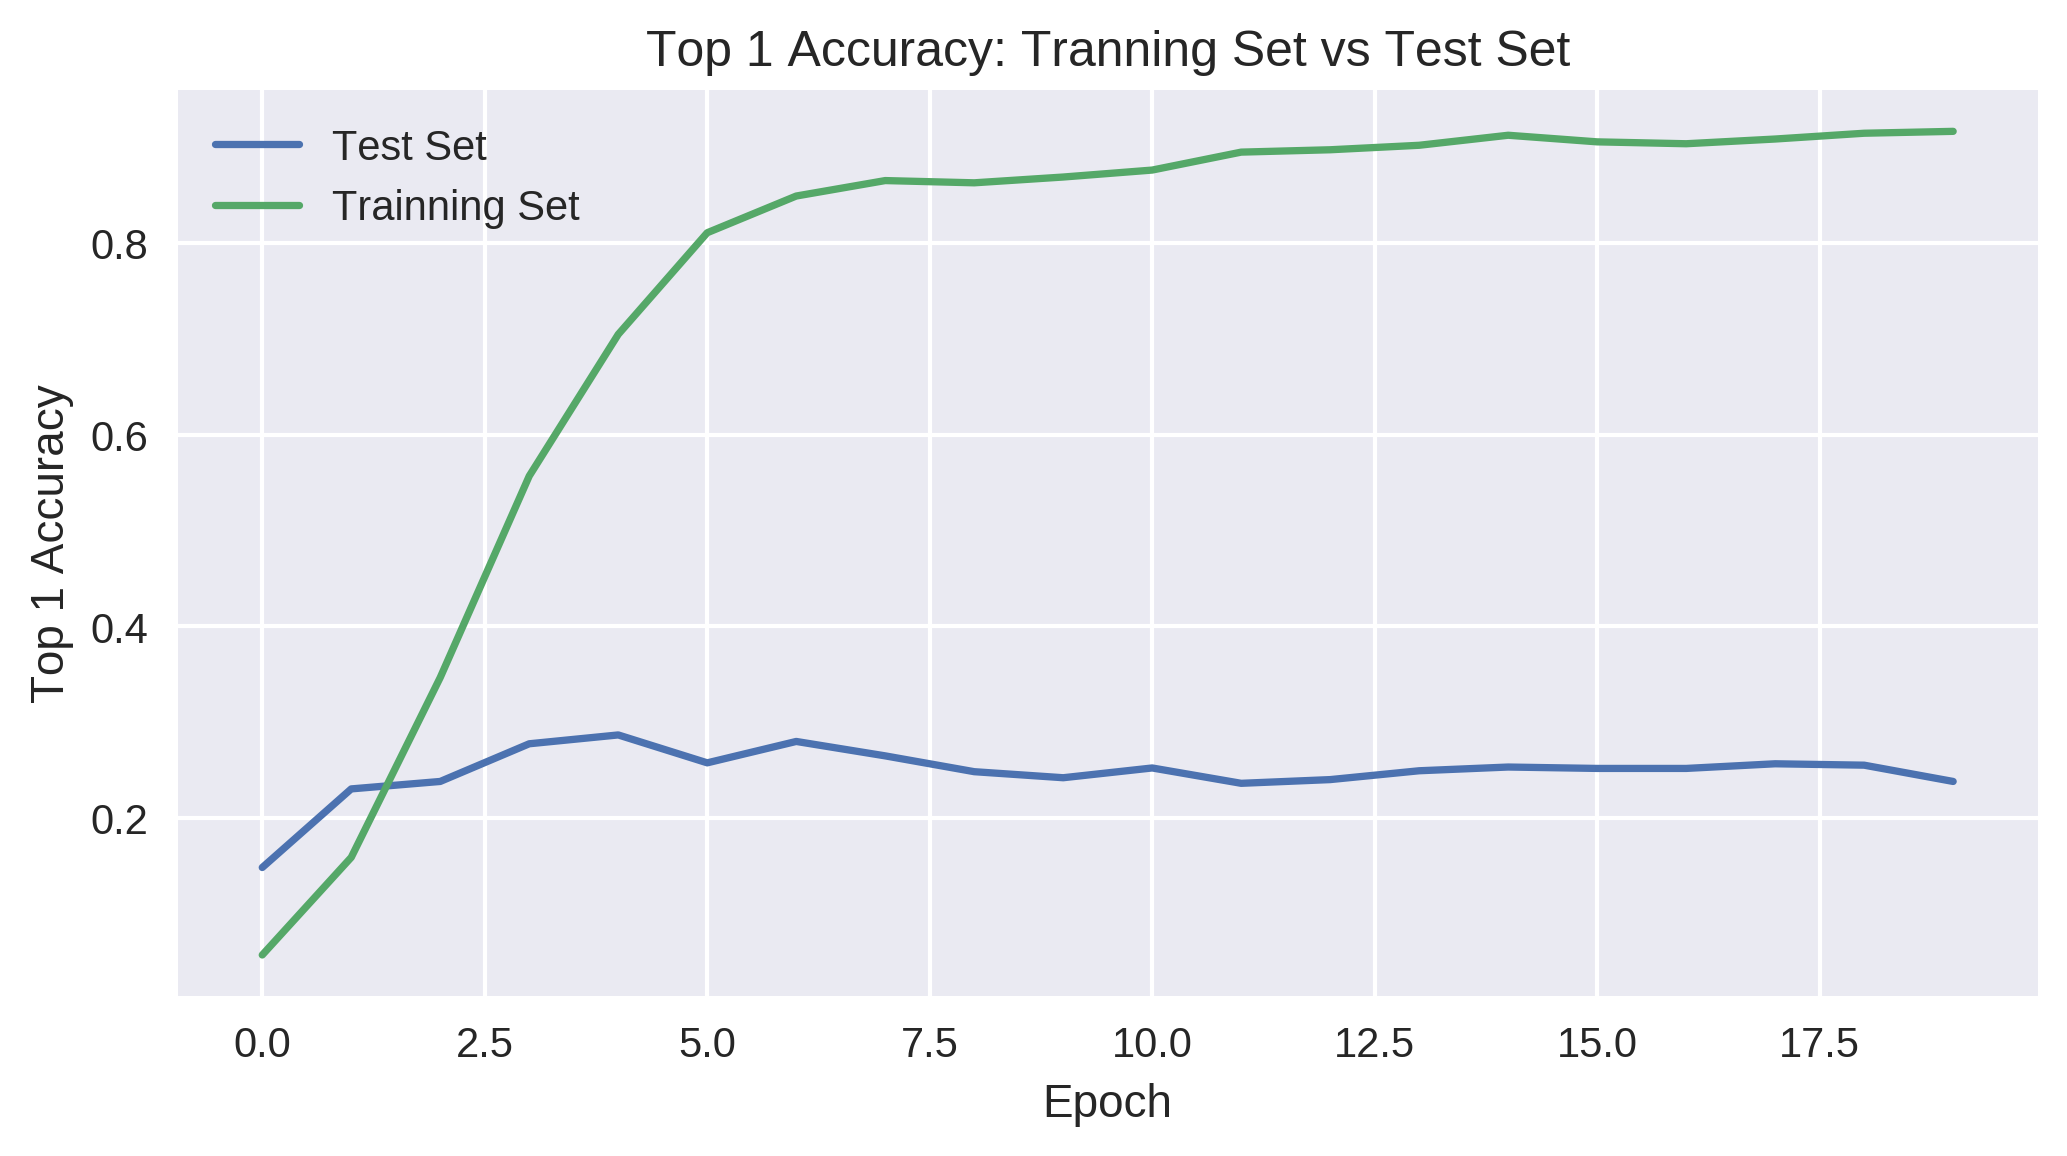

In [23]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

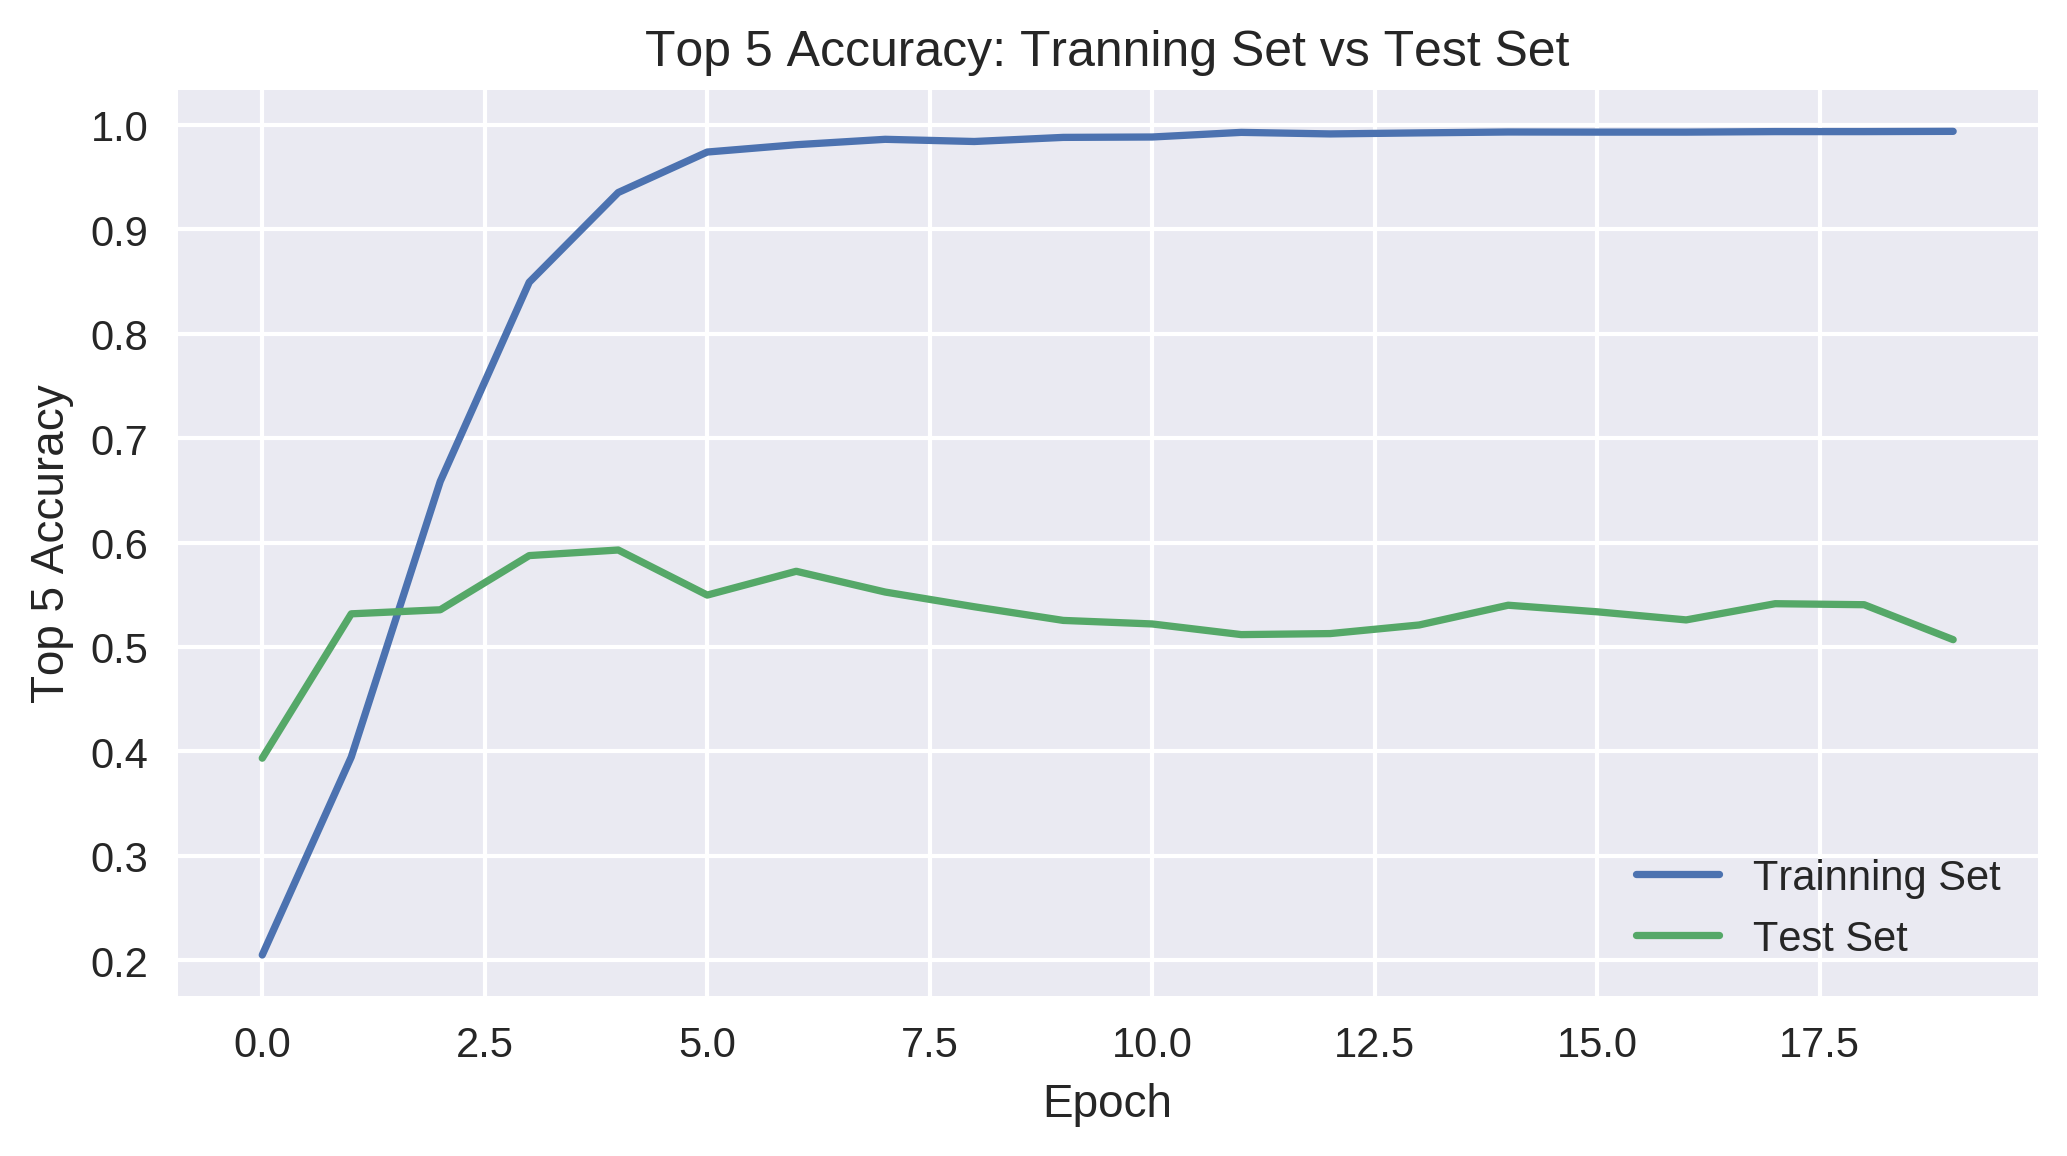

In [24]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()

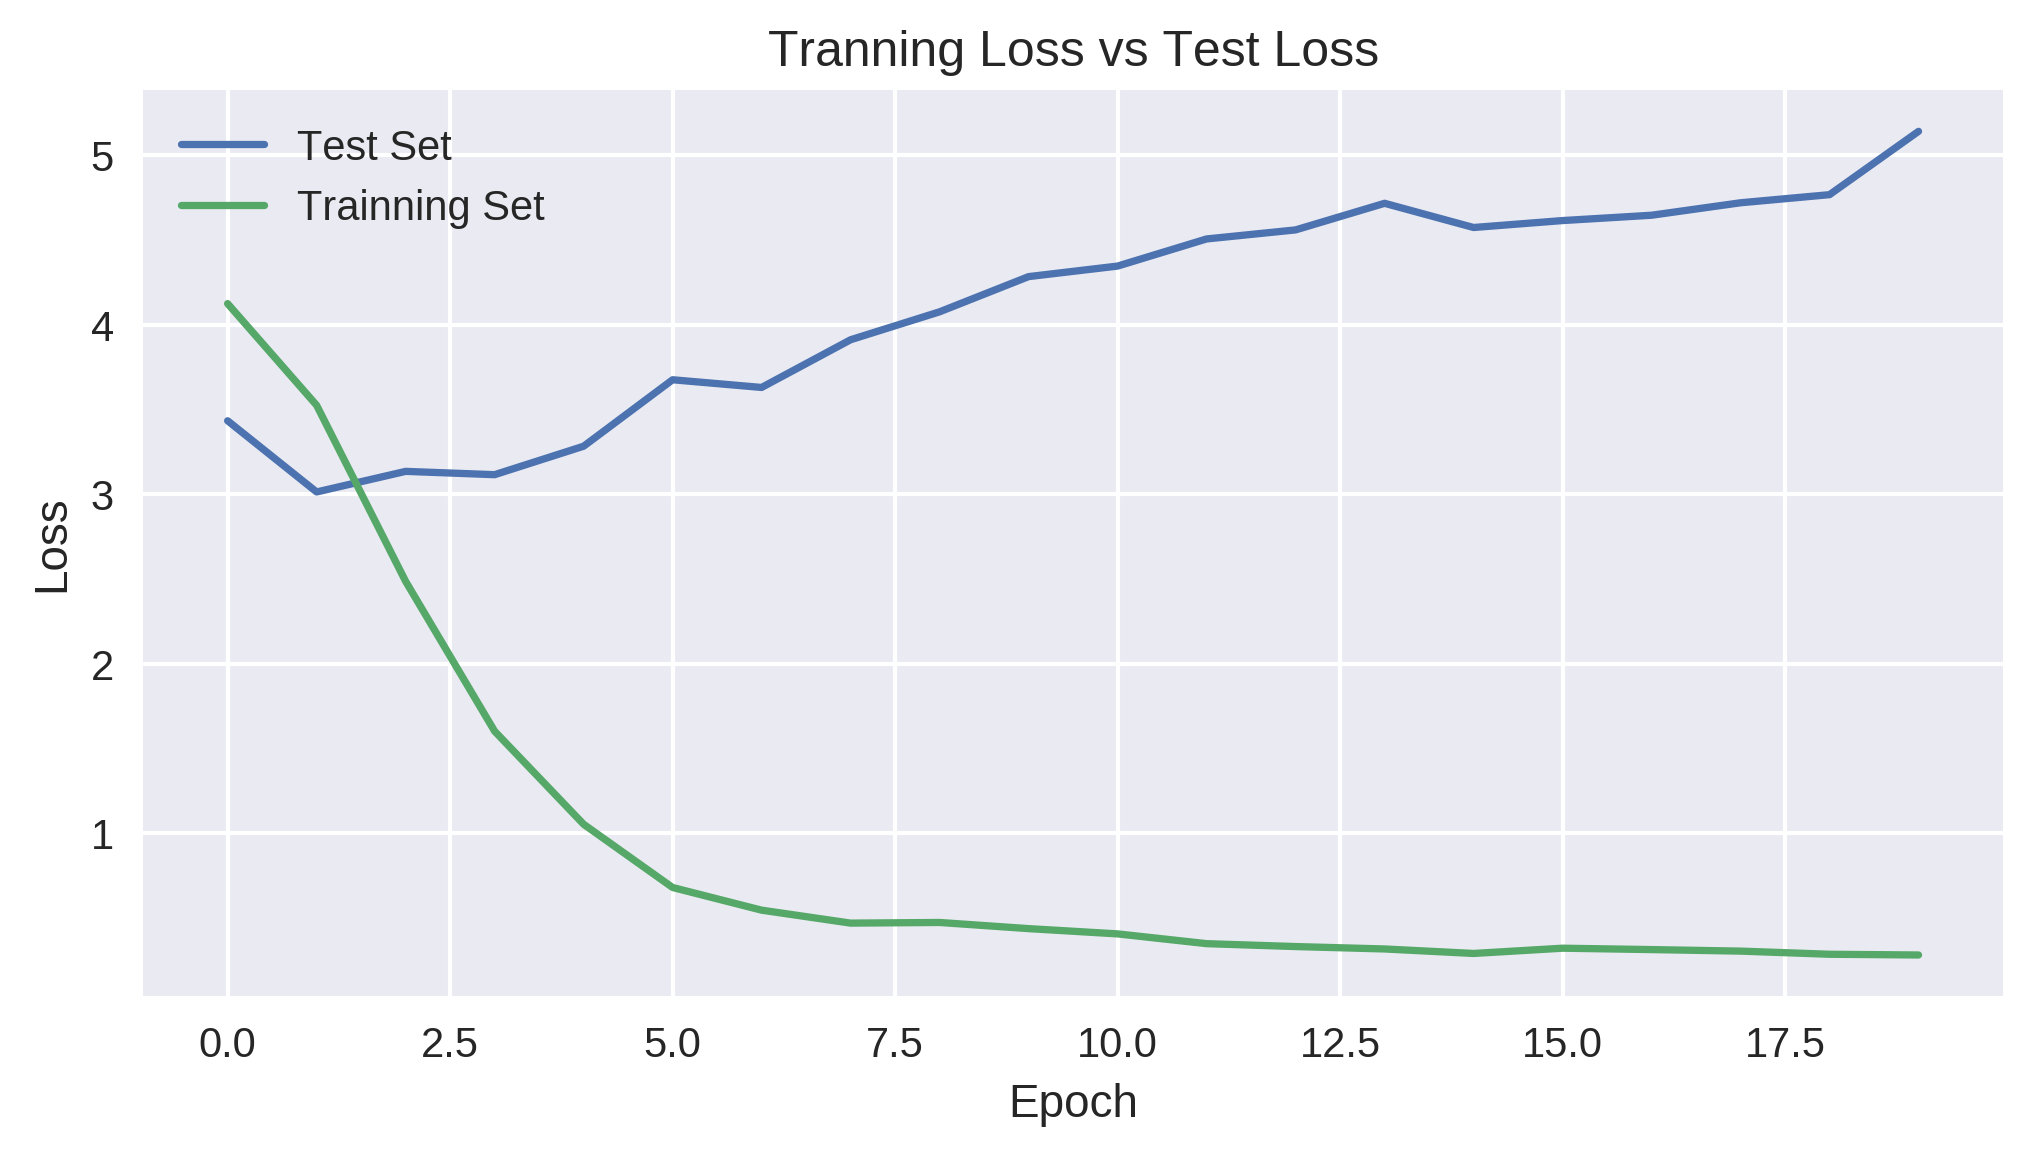

In [25]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()


### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryCNN', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
import pickle

f = open('ServeNet/trainHistoryCNN', 'rb')
his = pickle.load(f)
f.close()

In [30]:
val_top_k = his['val_top_k_categorical_accuracy']
print(max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print(min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print(max(val_ca))
print(np.argmax(val_ca))

0.5929160603095698
4
3.0122675874868334
1
0.2867540029545885
4


### Model Save

In [0]:
model.save('ServeNet/CNN.h5') 

### Model Load

In [0]:
model = load_model('ServeNet/CNN.h5')

In [33]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 18s 2ms/step
Training accuracy =  0.9657761910624154
Test set:
2061/2061 [==============================] - 4s 2ms/step
Training accuracy =  0.5070354198437764


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [35]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [36]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

14
21


In [37]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [39]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,3,3,1,16
Project Management,0,3,1,0,0,1,0,0,0,1,...,0,0,0,4,0,2,4,0,2,41
Banking,0,0,4,0,0,0,0,0,0,2,...,0,4,0,0,0,1,1,1,4,39
Backend,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,16
Shipping,0,2,2,0,6,1,0,0,0,0,...,1,0,0,0,0,0,2,0,0,28


In [40]:
sns.load_dataset("flights").head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


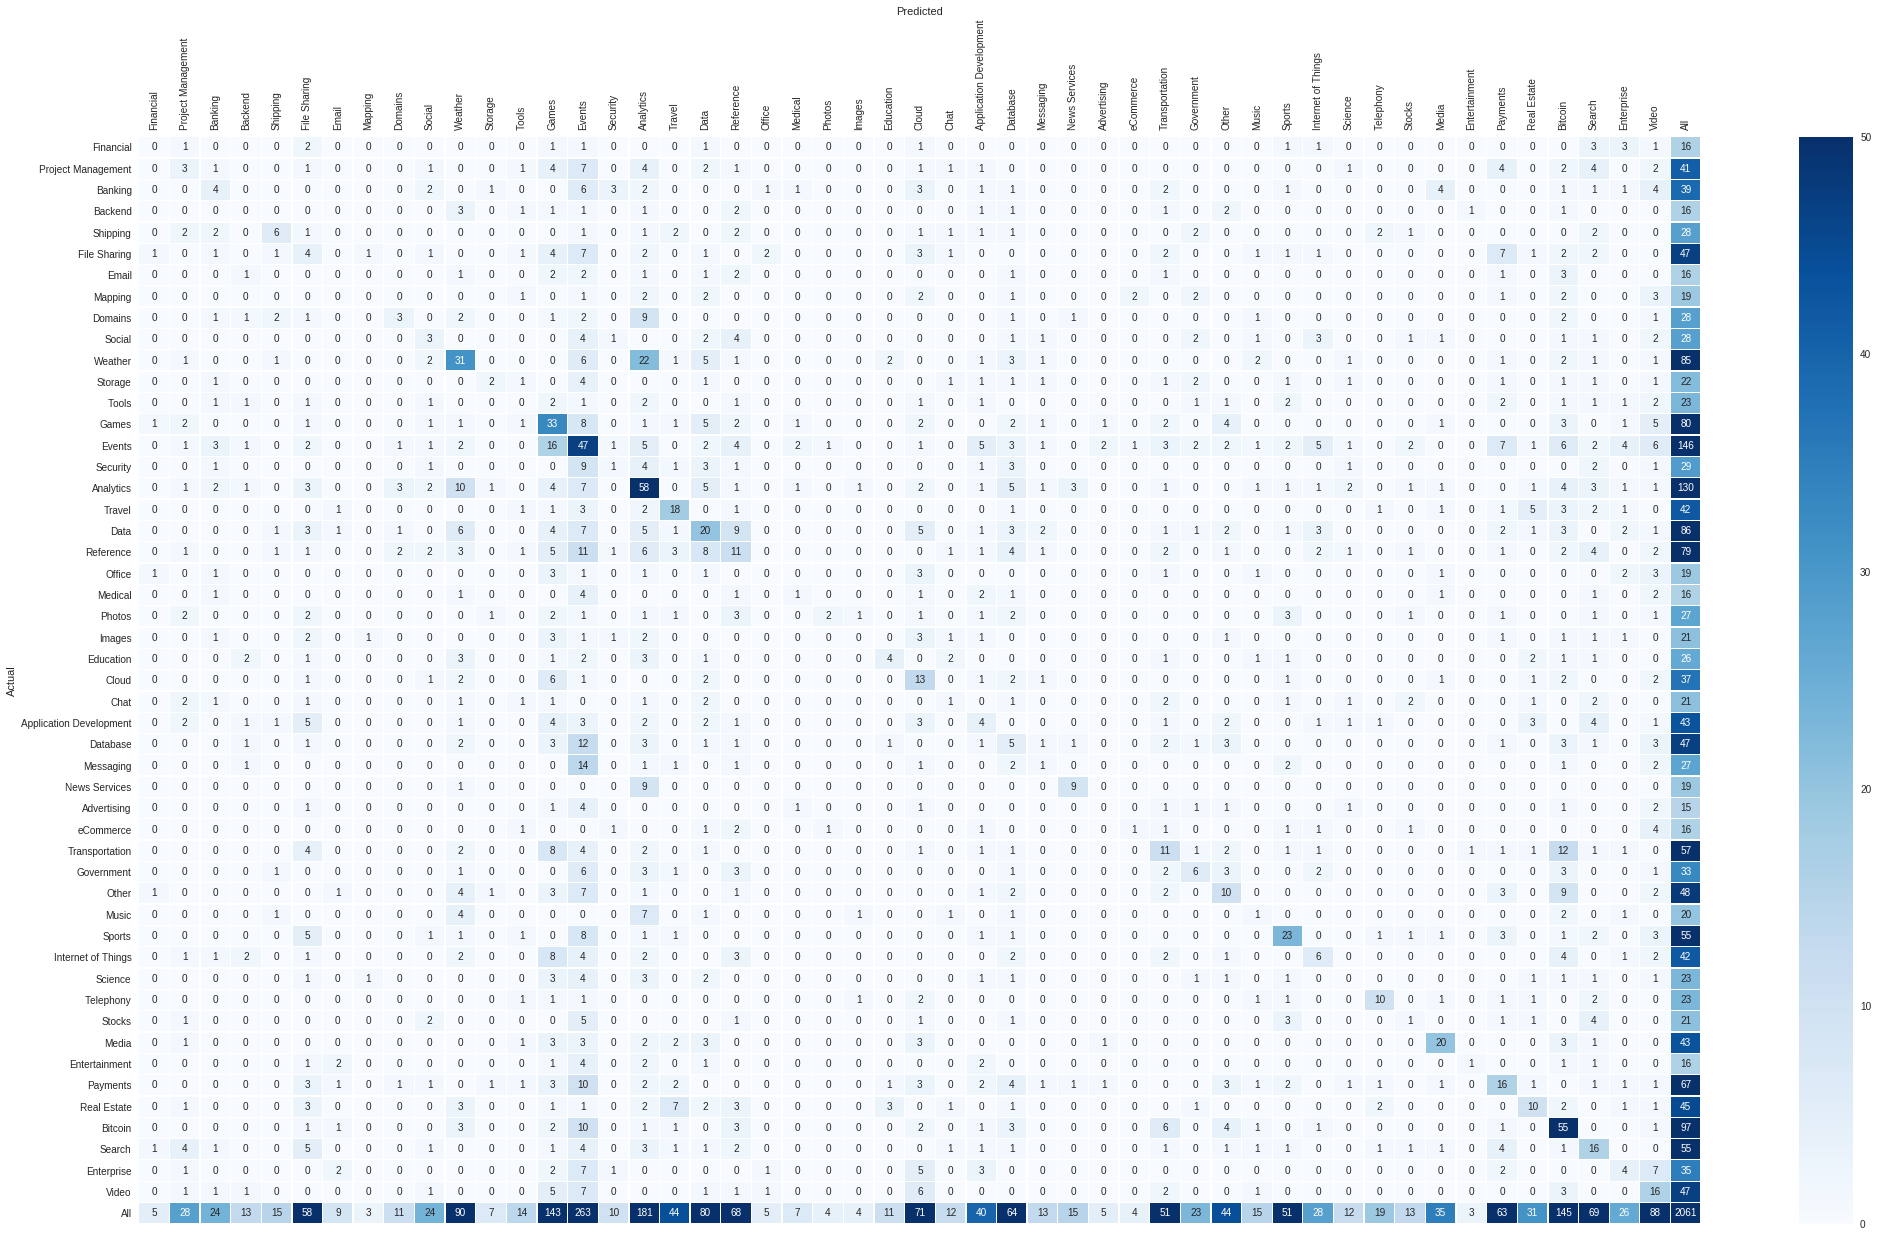

In [41]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/cnn.pdf', format='pdf', dpi=300)